In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.cm as cm
import pickle as pkl
import matplotlib.pyplot as plt
# Single methods
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH
import folium
from folium.plugins import HeatMap

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

In [4]:
root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"
model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


In [5]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)

In [46]:
df_ae

,y,0,1,2,3,4,5,6,7,8,...,25917,25918,25919,location,day,hour,hour_stage,cover,habitat,rain_FI
0,RZUA01_20220903_180000.WAV,12.614253,13.766678,13.452004,12.901808,9.231202,8.380487,13.543067,6.737097,12.728404,...,8.682384,7.944731,8.430065,RZUA01,3,18,night,pasture,bosque,NO
1,RZUA01_20220903_181500.WAV,8.868065,8.602959,8.032000,8.461406,8.115360,9.540920,8.448543,8.470122,8.716291,...,8.626004,8.789142,8.393890,RZUA01,3,18,night,pasture,bosque,NO
2,RZUA01_20220903_183000.WAV,8.439871,8.111892,8.229435,8.113555,10.578616,8.633891,8.527748,8.671189,8.124361,...,8.172195,7.136051,8.633291,RZUA01,3,18,night,pasture,bosque,NO
3,RZUA01_20220903_184500.WAV,7.227632,9.458550,8.812632,8.140289,8.898858,7.298670,9.649286,8.706988,7.528558,...,8.616589,8.696957,8.134158,RZUA01,3,18,night,pasture,bosque,NO
4,RZUA01_20220903_190000.WAV,8.435113,8.514136,9.329446,9.815832,9.877624,10.491020,8.917641,7.720235,9.814505,...,8.661306,8.625179,8.492565,RZUA01,3,19,night,pasture,bosque,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53270,RZUH13_20220912_070000.WAV,9.404017,9.351675,9.384949,9.301788,9.525492,9.158239,9.674375,9.141621,8.663704,...,8.728044,8.640818,8.863061,RZUH13,12,7,morning,pasture,borde,NO
53271,RZUH13_20220912_071500.WAV,9.916361,9.962175,10.101337,9.931640,9.921219,9.648269,9.766528,10.070633,9.762993,...,8.713860,8.716222,8.722901,RZUH13,12,7,morning,pasture,borde,NO
53272,RZUH13_20220912_073000.WAV,9.727241,10.147305,10.085156,9.866162,10.568411,9.736793,10.259166,10.049457,9.921656,...,8.719503,8.648980,8.750431,RZUH13,12,7,morning,pasture,borde,NO
53273,RZUH13_20220912_074500.WAV,9.961129,9.909297,9.855827,9.780950,9.849879,9.964485,9.557890,9.926011,9.993001,...,8.724940,8.731227,8.726334,RZUH13,12,7,morning,pasture,borde,NO


In [58]:
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)

In [56]:
df_ae.reset_index(inplace=True, drop=False)

In [60]:
df_ae

,y,0,1,2,3,4,5,6,7,8,...,25917,25918,25919,location,day,hour,hour_stage,cover,habitat,rain_FI
0,RZUA01_20220903_180000.WAV,12.614253,13.766678,13.452004,12.901808,9.231202,8.380487,13.543067,6.737097,12.728404,...,8.682384,7.944731,8.430065,RZUA01,3,18,night,pasture,bosque,NO
1,RZUA01_20220903_181500.WAV,8.868065,8.602959,8.032000,8.461406,8.115360,9.540920,8.448543,8.470122,8.716291,...,8.626004,8.789142,8.393890,RZUA01,3,18,night,pasture,bosque,NO
2,RZUA01_20220903_183000.WAV,8.439871,8.111892,8.229435,8.113555,10.578616,8.633891,8.527748,8.671189,8.124361,...,8.172195,7.136051,8.633291,RZUA01,3,18,night,pasture,bosque,NO
3,RZUA01_20220903_184500.WAV,7.227632,9.458550,8.812632,8.140289,8.898858,7.298670,9.649286,8.706988,7.528558,...,8.616589,8.696957,8.134158,RZUA01,3,18,night,pasture,bosque,NO
4,RZUA01_20220903_190000.WAV,8.435113,8.514136,9.329446,9.815832,9.877624,10.491020,8.917641,7.720235,9.814505,...,8.661306,8.625179,8.492565,RZUA01,3,19,night,pasture,bosque,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53270,RZUH13_20220912_070000.WAV,9.404017,9.351675,9.384949,9.301788,9.525492,9.158239,9.674375,9.141621,8.663704,...,8.728044,8.640818,8.863061,RZUH13,12,7,morning,pasture,borde,NO
53271,RZUH13_20220912_071500.WAV,9.916361,9.962175,10.101337,9.931640,9.921219,9.648269,9.766528,10.070633,9.762993,...,8.713860,8.716222,8.722901,RZUH13,12,7,morning,pasture,borde,NO
53272,RZUH13_20220912_073000.WAV,9.727241,10.147305,10.085156,9.866162,10.568411,9.736793,10.259166,10.049457,9.921656,...,8.719503,8.648980,8.750431,RZUH13,12,7,morning,pasture,borde,NO
53273,RZUH13_20220912_074500.WAV,9.961129,9.909297,9.855827,9.780950,9.849879,9.964485,9.557890,9.926011,9.993001,...,8.724940,8.731227,8.726334,RZUH13,12,7,morning,pasture,borde,NO


In [62]:
df_UMAP = df_ae.copy()
X_UMAP_df.index = df_UMAP.index
df_UMAP

,y,0,1,2,3,4,5,6,7,8,...,25917,25918,25919,location,day,hour,hour_stage,cover,habitat,rain_FI
0,RZUA01_20220903_180000.WAV,12.614253,13.766678,13.452004,12.901808,9.231202,8.380487,13.543067,6.737097,12.728404,...,8.682384,7.944731,8.430065,RZUA01,3,18,night,pasture,bosque,NO
1,RZUA01_20220903_181500.WAV,8.868065,8.602959,8.032000,8.461406,8.115360,9.540920,8.448543,8.470122,8.716291,...,8.626004,8.789142,8.393890,RZUA01,3,18,night,pasture,bosque,NO
2,RZUA01_20220903_183000.WAV,8.439871,8.111892,8.229435,8.113555,10.578616,8.633891,8.527748,8.671189,8.124361,...,8.172195,7.136051,8.633291,RZUA01,3,18,night,pasture,bosque,NO
3,RZUA01_20220903_184500.WAV,7.227632,9.458550,8.812632,8.140289,8.898858,7.298670,9.649286,8.706988,7.528558,...,8.616589,8.696957,8.134158,RZUA01,3,18,night,pasture,bosque,NO
4,RZUA01_20220903_190000.WAV,8.435113,8.514136,9.329446,9.815832,9.877624,10.491020,8.917641,7.720235,9.814505,...,8.661306,8.625179,8.492565,RZUA01,3,19,night,pasture,bosque,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53270,RZUH13_20220912_070000.WAV,9.404017,9.351675,9.384949,9.301788,9.525492,9.158239,9.674375,9.141621,8.663704,...,8.728044,8.640818,8.863061,RZUH13,12,7,morning,pasture,borde,NO
53271,RZUH13_20220912_071500.WAV,9.916361,9.962175,10.101337,9.931640,9.921219,9.648269,9.766528,10.070633,9.762993,...,8.713860,8.716222,8.722901,RZUH13,12,7,morning,pasture,borde,NO
53272,RZUH13_20220912_073000.WAV,9.727241,10.147305,10.085156,9.866162,10.568411,9.736793,10.259166,10.049457,9.921656,...,8.719503,8.648980,8.750431,RZUH13,12,7,morning,pasture,borde,NO
53273,RZUH13_20220912_074500.WAV,9.961129,9.909297,9.855827,9.780950,9.849879,9.964485,9.557890,9.926011,9.993001,...,8.724940,8.731227,8.726334,RZUH13,12,7,morning,pasture,borde,NO


In [18]:
mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X)
X_UMAP = mapper.transform(X)

In [52]:
import pandas as pd
import numpy as np

# Supongamos que `df_ae` es tu DataFrame original
# `X_UMAP` es el array con las características reducidas
# Convertimos X_UMAP a un DataFrame para manipularlo fácilmente
X_UMAP_df = pd.DataFrame(X_UMAP, columns=['UMAP1', 'UMAP2'])

# Crear una copia del DataFrame original
df_UMAP = df_ae.copy()

# Restablecemos los índices de X_UMAP_df para que coincidan con los de df_UMAP
X_UMAP_df.index = df_UMAP.index

# Restablecemos los índices de X_UMAP_df para que coincidan con los de df_UMAP
# Identificamos las columnas a reemplazar (0 a 25919)
cols_to_replace = [str(i) for i in range(25920)]  # Nombres de columnas como strings

# Verificamos cuáles de estas columnas existen en el DataFrame original
existing_cols = [col for col in cols_to_replace if col in df_UMAP.columns]

# Eliminamos esas columnas del nuevo DataFrame
df_UMAP = df_UMAP.drop(columns=existing_cols)

# Añadimos las nuevas columnas de X_UMAP al nuevo DataFrame
df_UMAP = pd.concat([df_UMAP, X_UMAP_df], axis=1)

# Mostramos el resultado final
print(df_UMAP)



                           location  day  hour hour_stage    cover habitat  \
Filename_                                                                    
RZUA01_20220903_180000.WAV   RZUA01    3    18      night  pasture  bosque   
RZUA01_20220903_181500.WAV   RZUA01    3    18      night  pasture  bosque   
RZUA01_20220903_183000.WAV   RZUA01    3    18      night  pasture  bosque   
RZUA01_20220903_184500.WAV   RZUA01    3    18      night  pasture  bosque   
RZUA01_20220903_190000.WAV   RZUA01    3    19      night  pasture  bosque   
...                             ...  ...   ...        ...      ...     ...   
RZUH13_20220912_070000.WAV   RZUH13   12     7    morning  pasture   borde   
RZUH13_20220912_071500.WAV   RZUH13   12     7    morning  pasture   borde   
RZUH13_20220912_073000.WAV   RZUH13   12     7    morning  pasture   borde   
RZUH13_20220912_074500.WAV   RZUH13   12     7    morning  pasture   borde   
RZUH13_20220912_080000.WAV   RZUH13   12     8    morning  pastu

In [81]:
Clustering = KMeans(n_clusters=10, random_state=0).fit(X_UMAP)
Results = ClusteringResults(Clustering, df_UMAP, y_label="hour")
df_new = Results.tagger()
df_new.set_index("y", inplace=True, drop=False)
df_new.rename_axis('Filename_', inplace=True)

audios_filtered = audios[audios.index.isin(df_new.index)]
audios_final = audios_filtered.join(df_new['cluster'], how='left')


conteo_clusters = audios_final.groupby(['location', 'cluster']).size().unstack(fill_value=0)
conteo_clusters.columns = [f'cluster_{col}' for col in conteo_clusters.columns]
recorders_clusters = recorders.join(conteo_clusters, on='field_number_PR')

In [96]:
cluster_centers_inverse.shape

(3, 5184)

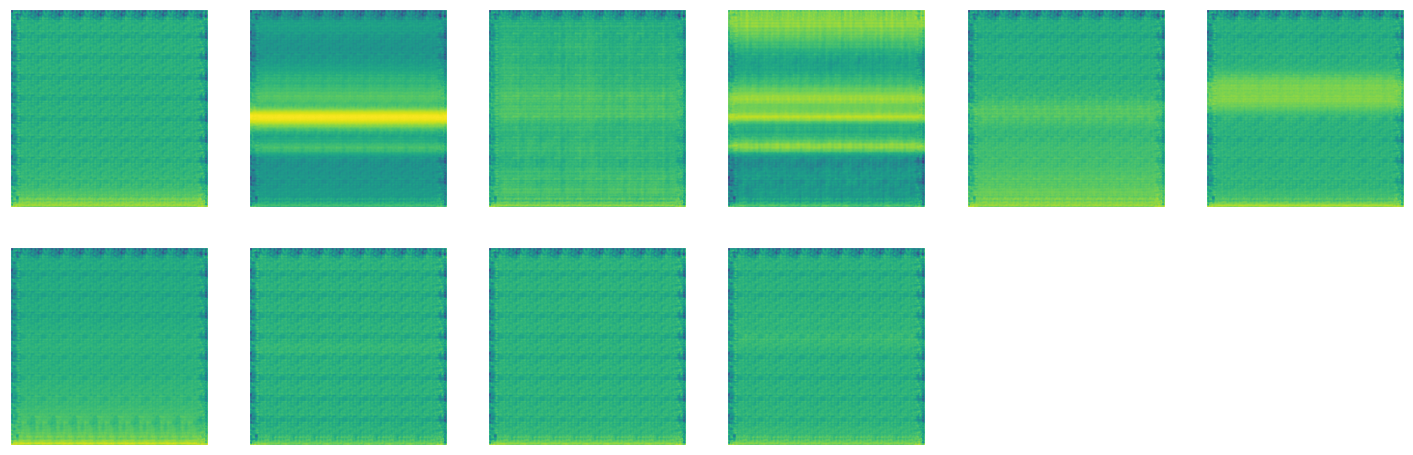

Ploted!


In [98]:
%matplotlib inline
cluster_centers = Clustering.cluster_centers_ #Normalizer_.inverse_transform(Kmeans.cluster_centers_)
cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
plot_centroids(cluster_centers_inverse, testing,) # save=True, #cluster_centers_inverse for UMAP, root=f"temporal_zamuro/zamuro_clustering_results/Kmeans_Normal/")

In [75]:
# Supongamos que quieres verificar los datos para una grabadora específica, por ejemplo, "grabadora_1"
grabadora = "RZUH12"  # Cambia esto al nombre de la grabadora que quieres verificar

# Filtrar los datos de audios_final para esta grabadora específica
audios_grabadora = audios_final[audios_final['location'] == grabadora]

# Contar la cantidad de audios en cada cluster para esta grabadora
conteo_por_cluster = audios_grabadora['cluster'].value_counts()

# Mostrar el resultado
print(conteo_por_cluster)

2    265
0    224
1    142
Name: cluster, dtype: int64


In [82]:
conteo_clusters = audios_final['cluster'].value_counts()

# Mostrar el resultado
print(conteo_clusters)

3    10309
5     9263
1     7925
4     7384
0     7273
6     4834
2     3716
9     1808
7      412
8      351
Name: cluster, dtype: int64


In [106]:
%matplotlib qt
mapa = folium.Map(location=[3.515, -73.411489], zoom_start=13.2)

puntos = recorders_clusters[['latitude_IG', 'longitud_IG', 'cluster_1']].values.tolist()
valores = recorders_clusters["cluster_1"].tolist()
HeatMap(puntos, radius=18, ).add_to(mapa)
mapa

In [ ]:
recorders

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

X= GLM[[f"Cluster {i}" for i in range(len(GLM.columns)-6)]]
X = X.to_numpy()
y = GLM["Mean"]